In [575]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader,TensorDataset,random_split
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import math
from torchsummary import summary

In [576]:
# 常量和超参数
round1_train_file = "./track1_round1_train_20210222.csv"
round1_testA_file = "./track1_round1_testA_20210222.csv"
local_test_result_file = "local_test_result.csv"
model_path = "./transformer_"
temp_model_store_path = "./transformer_temp.pth"
train_ratio = 0.8
quick_train_limit = 10000
is_under_sample = False
use_transformer = True
max_seq_length_limit = 120
#批次大小
batch_size = 20
# 定义嵌入维度
embedding_dim = 128
hidden_size = 128
output_size = 17
transformer_num_head = 1
transformer_num_layer = 1
#min_delta = 0.01
early_stop = 5
epoch = 100

In [577]:
df_train = pd.read_csv(round1_train_file, header=None)
df_train = df_train.iloc[:quick_train_limit]

In [578]:
df_train.columns = ["report_ID", "description", "label"]

In [579]:
df_train = df_train.map(lambda x: x.replace('|', '') if isinstance(x, str) else x)

In [580]:
df_train.head()

,report_ID,description,label
0,0,623 328 538 382 399 400 478 842 698 137 492 26...,2
1,1,48 328 538 382 809 623 434 355 382 382 363 145...,
2,2,623 656 293 851 636 842 698 493 338 266 369 69...,15
3,3,48 328 380 259 439 107 380 265 172 470 290 693...,
4,4,623 328 399 698 493 338 266 14 177 415 511 647...,16


In [581]:
print(df_train['label'].value_counts())

label
                   2622
15                  941
16                  777
2                   382
4                   317
                   ... 
0 1 8 15              6
3 4 7 11              6
0 1 4 7 8 9 11        6
1 2 9                 4
1 4 11 14 15          4
Name: count, Length: 102, dtype: int64


In [582]:
if is_under_sample:
    # 筛选出 label 为 [] 的数据
    empty_label_df = df_train[df_train['label'] == '']
    # 筛选出 label 不为 [] 的数据
    non_empty_label_df = df_train[df_train['label'] != '']
    
    # 对 label 为 [] 的数据进行抽样，抽样比例为 1/3
    sampled_empty_label_df = empty_label_df.sample(frac=1/3, random_state=42)
    
    # 合并抽样后的 [] 数据和非 [] 数据
    df_train = pd.concat([non_empty_label_df, sampled_empty_label_df])
    
    print(df_train['label'].value_counts())


In [583]:
df_train['label'] = df_train['label'].apply(lambda x: [int(i) for i in x.split()])

In [584]:
df_train

,report_ID,description,label
0,0,623 328 538 382 399 400 478 842 698 137 492 26...,[2]
1,1,48 328 538 382 809 623 434 355 382 382 363 145...,[]
2,2,623 656 293 851 636 842 698 493 338 266 369 69...,[15]
3,3,48 328 380 259 439 107 380 265 172 470 290 693...,[]
4,4,623 328 399 698 493 338 266 14 177 415 511 647...,[16]
...,...,...,...
9995,9995,290 380 247 263 48 328 697 582 91 400 478 842 ...,"[0, 7, 15]"
9996,9996,852 611 501 582 177 230 294 39 363 180 519 421...,[10]
9997,9997,852 328 290 380 256 544 636 90 735 374 698 116...,[]
9998,9998,852 328 305 461 382 697 259 779 59 261 589 693...,[16]


In [585]:
mlb = MultiLabelBinarizer(classes=list(range(output_size)))
label_vectors = mlb.fit_transform(df_train['label'])

In [586]:
print(df_train['label'][7])

[]


In [587]:
print("所有类别:", mlb.classes_)
# 查看转换后的二进制矩阵
print("转换后的二进制矩阵:\n", label_vectors)
print( label_vectors[7])

所有类别: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
转换后的二进制矩阵:
 [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [588]:
# 将字符串转换为数值列表
description_sequences = df_train['description'].apply(lambda x: [int(i) for i in x.split()])

# 找到最大序列长度
max_seq_length = max([len(seq) for seq in description_sequences])

# 限制最大序列长度（进一步降低）
max_seq_length = min(max_seq_length, max_seq_length_limit)

# 对序列进行填充
padded_sequences = []
#src_key_padding_masks = []

for seq in description_sequences:
    padded_seq = seq[:max_seq_length] + [0] * (max_seq_length - len(seq))
    #src_key_padding_mask = torch.zeros(max_seq_length).bool() 
    #src_key_padding_mask[len(seq):] = True
    padded_sequences.append(padded_seq)
    #src_key_padding_masks.append(src_key_padding_mask)

In [589]:
# 创建一个空的 DataFrame
df_transform = pd.DataFrame()

# 将 label_vectors 逐行转换为列表并存储到新列 'label_encoded' 中
df_transform['report_ID'] = df_train['report_ID']
df_transform['description'] = padded_sequences
# 不转出tuple就转不回去tensor了
df_transform['label'] = [tuple(row) for row in label_vectors]

In [590]:
df_transform

,report_ID,description,label
0,0,"[623, 328, 538, 382, 399, 400, 478, 842, 698, ...","(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[48, 328, 538, 382, 809, 623, 434, 355, 382, 3...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[623, 656, 293, 851, 636, 842, 698, 493, 338, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[48, 328, 380, 259, 439, 107, 380, 265, 172, 4...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[623, 328, 399, 698, 493, 338, 266, 14, 177, 4...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
9995,9995,"[290, 380, 247, 263, 48, 328, 697, 582, 91, 40...","(1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
9996,9996,"[852, 611, 501, 582, 177, 230, 294, 39, 363, 1...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
9997,9997,"[852, 328, 290, 380, 256, 544, 636, 90, 735, 3...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9998,9998,"[852, 328, 305, 461, 382, 697, 259, 779, 59, 2...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [591]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size,num_heads=1, num_layers=1):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = PositionalEncoding(embedding_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 线性层用于分类
        self.fc = nn.Linear(embedding_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(1, 0, 2)  # 转换为Transformer所需的形状 [seq_len, batch_size, embedding_dim]

        # 添加位置编码
        #embedded = self.positional_encoding(embedded)

        # Transformer Encoder
        transformer_output = self.transformer_encoder(embedded)  # [seq_len, batch_size, embedding_dim]
        #transformer_output = transformer_output.mean(dim=0)  # 取平均值作为序列的表示 [batch_size, embedding_dim]
        transformer_output = transformer_output[0,::]  # 取第一个token作为序列的表示 [batch_size, embedding_dim]
        # 分类层
        out = self.fc(transformer_output)  # [batch_size, output_size]
        return out

In [592]:
class TextClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(TextClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        # 线性层用于分类
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.float()
        out1, (h_n, h_c) = self.lstm_layer(embedded)
        # 对时间步求平均值
        out = out1.mean(dim=1)  # [batch_size, hidden_size]
        # 最后一个时间步的隐藏状态,效果不好
        #out = h_n[-1] # [batch_size, hidden_size]
        # 分类层
        out = self.fc(out)  # [batch_size, output_size]

        return out

In [593]:
# 将填充后的序列转换为 PyTorch 张量
#x_train = torch.tensor(padded_sequences, dtype=torch.long)
#y_train = torch.from_numpy(label_vectors).float()

x_train = torch.tensor(df_transform['description'], dtype=torch.long)
y_train = torch.tensor(df_transform['label'], dtype=torch.float)

#用多少数据训练
total_sample_num = len(x_train)
train_sample_num = round(train_ratio * total_sample_num)
validate_sample_num = round((total_sample_num - train_sample_num)/2)
test_sample_num = total_sample_num - train_sample_num - validate_sample_num

train_data = TensorDataset(x_train, y_train)

train_dataset, val_dataset, test_dataset = random_split(train_data, [train_sample_num, validate_sample_num, test_sample_num])



train_dataLoader = DataLoader(train_dataset, batch_size=batch_size)
val_dataLoader = DataLoader(val_dataset, batch_size=batch_size)

In [594]:
#初始化模型
vocab_size = max([max(seq) for seq in description_sequences]) + 1

if use_transformer:
    model = TextClassifier(vocab_size, embedding_dim, hidden_size, output_size, num_heads=transformer_num_head, num_layers=transformer_num_layer)
else:
    model = TextClassifierLSTM(vocab_size, embedding_dim, hidden_size, output_size)

#反向传播算法 SGD Adam等
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#损失函数
criterion =	torch.nn.BCEWithLogitsLoss ()
# 加载第一次训练的参数
#if train_ratio == 1:
#    model.load_state_dict(torch.load(model_store_path))

D:\AI\anaconda3\envs\py3_12\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [595]:
model

TextClassifier(
  (embedding): Embedding(858, 128)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=17, bias=True)
)

In [596]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型参数数量:{total_params}")

模型参数数量:705041


In [597]:
#记录用于绘图
losses = []#记录每次迭代后训练的loss
eval_losses = []#测试的
train_loss = 0
eval_loss = 0
best_model = None
best_loss = 100
epoch_cnt = 0


for i in range(epoch):
    total_train_loss = 0
    total_test_loss = 0
    # train_acc = 0
    model.train() #网络设置为训练模式 暂时可加可不加
    for tdata,tlabel in tqdm(train_dataLoader,desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(i, train_loss, eval_loss)):
        #前向传播
        y_ = model(tdata)
        #print(f"y_标签类型: {y_.dtype}")
        #print(f"y_标标签形状: {y_.shape}")
        #print(f"目标标签类型: {tlabel.dtype}")
        #print(f"目标标签形状: {tlabel.shape}")
        #反向传播
        #记录单批次一次batch的loss
        loss = criterion(y_, tlabel)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #累计单批次误差
        total_train_loss = total_train_loss + loss.item()

    train_loss = (total_train_loss / len(train_dataLoader))
    losses.append(train_loss)
    
    # 测试集进行测试

    model.eval()  # 可加可不加
    for edata, elabel in val_dataLoader:
        # 前向传播
        y_ = model(edata)
        # 记录单批次一次batch的loss，测试集就不需要反向传播更新网络了
        loss = criterion(y_, elabel)
        # 累计单批次误差
        total_test_loss = total_test_loss + loss.item()

    eval_loss = total_test_loss / len(val_dataLoader)
    eval_losses.append(eval_loss)

    if best_loss > eval_loss :
        # 找到一个更好的model，重置早停计数器
        epoch_cnt = 0
        best_loss = eval_loss
        best_model = copy(model)
    else:
        epoch_cnt += 1

    if i % 10 == 0:
        torch.save(copy(model).state_dict(), temp_model_store_path)
    if epoch_cnt >= early_stop:
        model_path = model_store_path + 'epoch_no_'+ str(i) + '.pth'
        torch.save(best_model.state_dict(), model_path,)
        break

if epoch_cnt < early_stop:
    torch.save(copy(model).state_dict(), model_path,)

Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|█████████████████████████████████████████| 400/400 [00:23<00:00, 16.87it/s]
Epoch: 1| Train Loss: 0.2910438546165824| Test Loss: 0.26183650553226473: 100%|██████| 400/400 [00:23<00:00, 16.90it/s]
Epoch: 2| Train Loss: 0.25806367553770543| Test Loss: 0.25985250174999236: 100%|█████| 400/400 [00:23<00:00, 16.96it/s]
Epoch: 3| Train Loss: 0.25647579442709684| Test Loss: 0.2591937783360481: 100%|██████| 400/400 [00:24<00:00, 16.39it/s]
Epoch: 4| Train Loss: 0.25487233959138395| Test Loss: 0.2585873681306839: 100%|██████| 400/400 [00:23<00:00, 16.69it/s]
Epoch: 5| Train Loss: 0.25355402421206236| Test Loss: 0.25873770743608476: 100%|█████| 400/400 [00:23<00:00, 16.73it/s]
Epoch: 6| Train Loss: 0.25257713537663223| Test Loss: 0.2588615399599075: 100%|██████| 400/400 [00:23<00:00, 16.67it/s]
Epoch: 7| Train Loss: 0.2511673509329557| Test Loss: 0.25906462520360946: 100%|██████| 400/400 [00:23<00:00, 16.74it/s]
Epoch: 8| Train Loss: 0.2497146284580230

In [598]:
# 从 test_dataset 中提取 x_test 和 y_test
x_test = []
y_test = []
for inputs, labels in test_dataset:
    #if not torch.equal(labels,torch.zeros( output_size)):
    x_test.append(inputs)
    y_test.append(labels)

# 将列表转换为张量
x_test = torch.stack(x_test)
y_test = torch.stack(y_test)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: torch.Size([1000, 104])
y_test shape: torch.Size([1000, 17])


In [599]:
# 测试最终模型的精准度，测试集的平均误差
model.load_state_dict(torch.load(model_path))
y_pre = model(x_test)

In [600]:
# 随便乱猜的准确率和交叉熵是0%和0.8
#y_pre = torch.randn(test_sample_num,output_size)

# 打印y_pre的概率值
print("模型结果:")
print(y_pre)
print("预测概率值:")
y_pre_p = torch.sigmoid(y_pre)
# 猜0的准确率和交叉熵是24%和0.8
#y_pre_p = torch.zeros(test_sample_num, output_size)

print(y_pre_p)

#predicted_classes = torch.round(torch.sigmoid(y_pre))
# 自定义阈值（例如 0.5）进行映射
threshold = 0.5
predicted_classes = (y_pre_p >= threshold).float()

# 获取真实值
true_classes = y_test
print("真实值:")
print(true_classes)
# 手动计算二元交叉熵损失
loss = - (true_classes * torch.log(y_pre_p) + (1 - true_classes) * torch.log(1 - y_pre_p))
# 对每个样本的损失求平均
average_loss = loss.mean()

print(f"手动计算的损失值: {average_loss.item()}")
# 计算平均误差
loss = criterion(y_pre, true_classes)
print(f"criterion计算测试集平均误差 (交叉熵损失): {loss.item():.4f}")

模型结果:
tensor([[-2.5429, -2.6016, -2.9504,  ..., -2.9543, -1.8797, -2.7046],
        [-1.6995, -2.1046, -2.1285,  ..., -4.0474, -0.6561, -2.8579],
        [-2.6204, -1.1785, -3.1006,  ..., -3.6216, -2.1263, -3.1951],
        ...,
        [-2.3732, -1.8981, -1.8410,  ..., -3.5550, -1.8657, -3.0555],
        [-2.3732, -1.8981, -1.8410,  ..., -3.5550, -1.8657, -3.0555],
        [-2.2383, -2.3593, -2.9376,  ..., -3.9429, -0.6256, -2.8731]],
       grad_fn=<AddmmBackward0>)
预测概率值:
tensor([[0.0729, 0.0690, 0.0497,  ..., 0.0495, 0.1324, 0.0627],
        [0.1545, 0.1086, 0.1064,  ..., 0.0172, 0.3416, 0.0543],
        [0.0678, 0.2353, 0.0431,  ..., 0.0260, 0.1066, 0.0393],
        ...,
        [0.0852, 0.1303, 0.1369,  ..., 0.0278, 0.1340, 0.0450],
        [0.0852, 0.1303, 0.1369,  ..., 0.0278, 0.1340, 0.0450],
        [0.0964, 0.0863, 0.0503,  ..., 0.0190, 0.3485, 0.0535]],
       grad_fn=<SigmoidBackward0>)
真实值:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
  

In [601]:
# 将编码后的数据还原为原始标签形式
pred_labels = mlb.inverse_transform(predicted_classes.detach())
# 获取真实值
true_label = mlb.inverse_transform(true_classes)

pred_list = [[int(item) for item in sublist] for sublist in pred_labels]
true_list = [[int(item) for item in sublist] for sublist in true_label]
true_classes_list = [[int(item) for item in sublist] for sublist in true_classes]
y_pre_list = [[float(item) for item in sublist] for sublist in y_pre]
y_pre_p_list = [[float(item) for item in sublist] for sublist in y_pre_p]
df_compare = pd.DataFrame({'target': true_list,'predict': pred_list,'target_classes':true_classes_list,'predict_l': y_pre_list,'predict_p': y_pre_p_list})
df_compare.to_csv(local_test_result_file)
df_compare.head(10)

,target,predict,target_classes,predict_l,predict_p
0,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.5429089069366455, -2.601571559906006, -2.9...","[0.0729043185710907, 0.06903734803199768, 0.04..."
1,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
2,"[1, 8]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[-2.6203713417053223, -1.1785112619400024, -3....","[0.06783880293369293, 0.23531998693943024, 0.0..."
3,"[0, 7]",[],"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
4,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
5,[15],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
6,"[6, 13]",[],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
7,[4],[],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.7858848571777344, -2.757934093475342, -2.8...","[0.05809171497821808, 0.059640124440193176, 0...."
8,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
9,[16],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.9664621353149414, -2.5359046459198, -3.008...","[0.048964206129312515, 0.07337915152311325, 0...."


In [602]:
# 预测正确的部分
df_compare_correct = df_compare[(df_compare['target'] == df_compare['predict'])]
df_compare_correct.head()

,target,predict,target_classes,predict_l,predict_p
0,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.5429089069366455, -2.601571559906006, -2.9...","[0.0729043185710907, 0.06903734803199768, 0.04..."
1,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
4,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
8,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
10,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.491987466812134, -2.9318888187408447, -3.0...","[0.07642180472612381, 0.050599511712789536, 0...."


In [603]:
print('本地测试样本数量：',len(x_test))
print('预测正确的样本数量：',len(df_compare_correct))
accuracy = len(df_compare_correct)/len(x_test)
print(f"模型精准度: {accuracy * 100:.2f}%")
if len(df_compare_correct)>0:
    correct_zero_num = (df_compare_correct['predict'].apply(lambda x: x == [])).sum().item()
    correct_negative_rate = correct_zero_num/len(df_compare_correct) * 100
else:
    correct_zero_num = 0
    correct_negative_rate = 0
print('预测正确的样本中的负值数量：',correct_zero_num)
print(f"预测正确的样本中的负值数量占比：{correct_negative_rate:.2f}%")

本地测试样本数量： 1000
预测正确的样本数量： 281
模型精准度: 28.10%
预测正确的样本中的负值数量： 280
预测正确的样本中的负值数量占比：99.64%


In [604]:
# 预测不正确的部分
df_compare[(df_compare['target'] != df_compare['predict'])]

,target,predict,target_classes,predict_l,predict_p
2,"[1, 8]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[-2.6203713417053223, -1.1785112619400024, -3....","[0.06783880293369293, 0.23531998693943024, 0.0..."
3,"[0, 7]",[],"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
5,[15],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
6,"[6, 13]",[],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[-1.6995161771774292, -2.1046268939971924, -2....","[0.15452846884727478, 0.10864792764186859, 0.1..."
7,[4],[],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.7858848571777344, -2.757934093475342, -2.8...","[0.05809171497821808, 0.059640124440193176, 0...."
...,...,...,...,...,...
991,[5],[],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-3.1070237159729004, -3.000922441482544, -3.6...","[0.04281846061348915, 0.047384217381477356, 0...."
992,[15],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."
995,"[4, 5, 11, 12, 15]",[],"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[-3.1288912296295166, -2.410531997680664, -3.1...","[0.04193112626671791, 0.08237309753894806, 0.0..."
997,"[1, 2]",[],"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-2.3732309341430664, -1.8980947732925415, -1....","[0.08523687720298767, 0.13032425940036774, 0.1..."


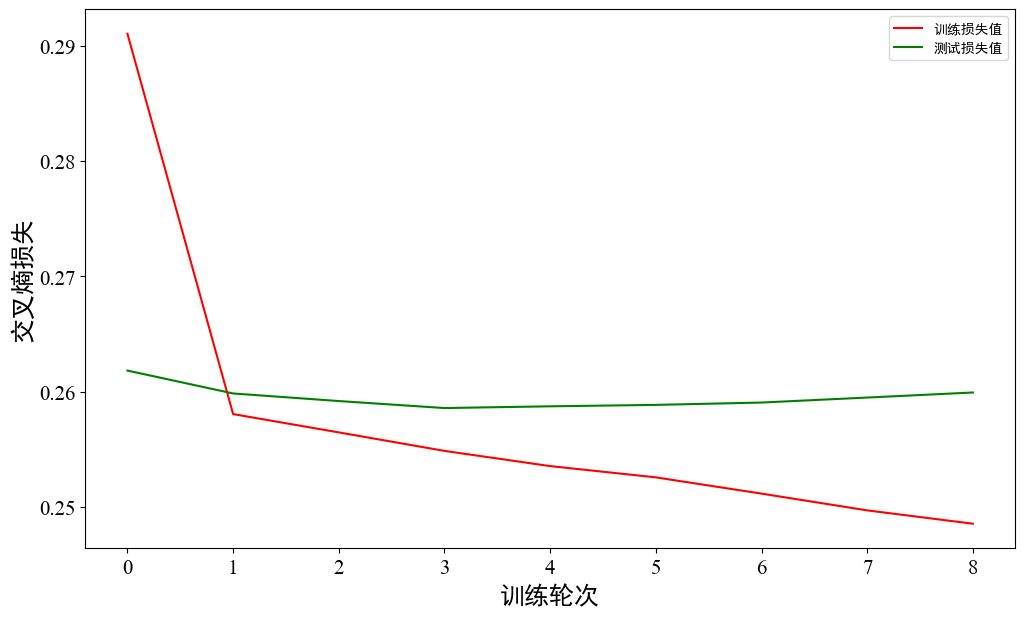

In [605]:
# 画出训练集损失和验证集损失
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(12, 7))
plt.plot(range(len(losses)), losses, label = "训练损失值", color='red')
plt.plot(range(len(eval_losses)), eval_losses, label = "测试损失值",color='green')

plt.xticks(fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xlabel('训练轮次', fontsize=18)
plt.ylabel('交叉熵损失', fontsize=18)
plt.legend()
plt.show()

In [606]:
# 对测试集A进行转换
df_testA = pd.read_csv(round1_testA_file, header=None)
df_testA.columns = ["report_ID", "description"]
df_testA = df_testA.map(lambda x: x.replace('|', '') if isinstance(x, str) else x)

# 将字符串转换为数值列表
description_sequences_testA = df_testA['description'].apply(lambda x: [int(i) for i in x.split()])

# 对序列进行填充
padded_sequences_testA = []
for seq in description_sequences_testA:
    padded_seq_testA = seq[:max_seq_length] + [0] * (max_seq_length- len(seq))
    padded_sequences_testA.append(padded_seq_testA)

padded_sequences_testA
# 将填充后的序列转换为 PyTorch 张量
x_testA = torch.tensor(padded_sequences_testA, dtype=torch.long)

In [607]:
# 在测试集应用模型
model.load_state_dict(torch.load(model_path))
y_pre_testA = model(x_testA)
# 打印y_pre_testA的概率值
print("模型结果:")
print(y_pre_testA)

模型结果:
tensor([[-3.1073, -3.0003, -3.6702,  ..., -3.2092, -1.9783, -2.6217],
        [-2.4795, -2.9286, -3.0010,  ..., -2.0603, -1.7464, -1.9403],
        [-2.5101, -2.2900, -2.7708,  ..., -3.2799, -1.1300, -2.6170],
        ...,
        [-1.6990, -2.1020, -2.1240,  ..., -4.0450, -0.6550, -2.8592],
        [-2.8450, -2.1475, -2.6831,  ..., -3.6678, -1.6437, -2.6442],
        [-2.8062, -2.4787, -2.9665,  ..., -3.1103, -0.5821, -2.2404]],
       grad_fn=<AddmmBackward0>)


In [608]:
print("预测概率值:")
y_pre_testA_p = torch.sigmoid(y_pre_testA)
#y_pre_testA_p = torch.zeros(len(x_testA), output_size)
print(y_pre_testA_p)

预测概率值:
tensor([[0.0428, 0.0474, 0.0248,  ..., 0.0388, 0.1215, 0.0678],
        [0.0773, 0.0508, 0.0474,  ..., 0.1130, 0.1485, 0.1256],
        [0.0752, 0.0920, 0.0589,  ..., 0.0363, 0.2442, 0.0681],
        ...,
        [0.1546, 0.1089, 0.1068,  ..., 0.0172, 0.3419, 0.0542],
        [0.0549, 0.1046, 0.0640,  ..., 0.0249, 0.1620, 0.0663],
        [0.0570, 0.0774, 0.0490,  ..., 0.0427, 0.3584, 0.0962]],
       grad_fn=<SigmoidBackward0>)


In [609]:
pred_testA_df = pd.DataFrame(y_pre_testA_p.detach().numpy())
pred_testA_df = pred_testA_df.apply(lambda x: [round(i,2) for i in x])
# 提取后 output_size 列
last_output_size_columns = pred_testA_df.iloc[:, -output_size:]

# 将后 output_size 列的元素用空格连接成字符串
pred_testA_df['Prediction'] = last_output_size_columns.astype(str).agg(' '.join, axis=1)

# 删除后 output_size 列
pred_testA_df = pred_testA_df.drop(last_output_size_columns.columns, axis=1)
pred_testA_df

,Prediction
0,0.04 0.05 0.02 0.02 0.05 0.01 0.01 0.12 0.16 0...
1,0.08 0.05 0.05 0.02 0.07 0.02 0.02 0.06 0.05 0...
2,0.08 0.09 0.06 0.03 0.07 0.03 0.02 0.06 0.07 0...
3,0.09 0.13 0.14 0.1 0.17 0.03 0.04 0.02 0.04 0....
4,0.08 0.04 0.06 0.02 0.06 0.06 0.02 0.07 0.08 0...
...,...
2995,0.07 0.07 0.06 0.03 0.08 0.02 0.02 0.07 0.08 0...
2996,0.14 0.09 0.06 0.02 0.16 0.04 0.02 0.12 0.1 0....
2997,0.15 0.11 0.11 0.02 0.29 0.1 0.02 0.16 0.12 0....
2998,0.05 0.1 0.06 0.03 0.08 0.03 0.02 0.06 0.07 0....


In [610]:
# 合并2列
df_result = pd.concat([df_testA["report_ID"], pred_testA_df], axis=1)
df_result

,report_ID,Prediction
0,0,0.04 0.05 0.02 0.02 0.05 0.01 0.01 0.12 0.16 0...
1,1,0.08 0.05 0.05 0.02 0.07 0.02 0.02 0.06 0.05 0...
2,2,0.08 0.09 0.06 0.03 0.07 0.03 0.02 0.06 0.07 0...
3,3,0.09 0.13 0.14 0.1 0.17 0.03 0.04 0.02 0.04 0....
4,4,0.08 0.04 0.06 0.02 0.06 0.06 0.02 0.07 0.08 0...
...,...,...
2995,2995,0.07 0.07 0.06 0.03 0.08 0.02 0.02 0.07 0.08 0...
2996,2996,0.14 0.09 0.06 0.02 0.16 0.04 0.02 0.12 0.1 0....
2997,2997,0.15 0.11 0.11 0.02 0.29 0.1 0.02 0.16 0.12 0....
2998,2998,0.05 0.1 0.06 0.03 0.08 0.03 0.02 0.06 0.07 0....


In [611]:
# 将 report_ID 列转换为整数类型
df_result['report_ID'] = df_result['report_ID'].astype(int)
df_result['Prediction'] = df_result['Prediction'].astype(str)

In [612]:
round1_testA_pre_file = 'testA_pre.csv'
df_result.to_csv(round1_testA_pre_file,index=False,header=False)

In [613]:
# 读取临时文件并替换分隔符
with open(round1_testA_pre_file, 'r') as f:
    content = f.read()

# 将逗号替换为 |,|
content = content.replace(',', '|,|')

# 保存为最终文件
final_file_path = 'output.csv'
with open(final_file_path, 'w') as f:
    f.write(content)

In [614]:
#探索数据
# 找到最大序列长度
print("训练集样本个数：",len(description_sequences))
print("测试集样本个数：",len(description_sequences_testA))
print("训练集的description最大长度：",max([len(seq) for seq in description_sequences]))
print("测试集的description最大长度：",max([len(seq) for seq in description_sequences_testA]))
print("训练集description最大值：",max([max(seq) for seq in description_sequences]) + 1)
print("测试集description最大值：",max([max(seq) for seq in description_sequences_testA]) + 1)

negative_num = [sum(i) for i in label_vectors.tolist()].count(0)
multi_label_num = train_sample_num - [sum(i) for i in label_vectors.tolist()].count(0) - [sum(i) for i in label_vectors.tolist()].count(1)
print("训练集标签为空的个数:",negative_num)
print(f"负例占比：{negative_num/train_sample_num * 100:.2f}%")
print("训练集有多个分类标签的个数:",multi_label_num)     

训练集样本个数： 10000
测试集样本个数： 3000
训练集的description最大长度： 104
测试集的description最大长度： 102
训练集description最大值： 858
测试集description最大值： 858
训练集标签为空的个数: 2622
负例占比：32.77%
训练集有多个分类标签的个数: 961


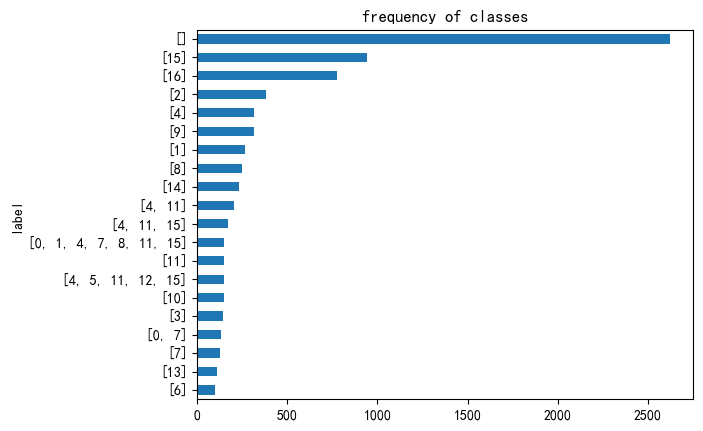

In [615]:
df_train['label'].value_counts(ascending=True)[-20:].plot.barh()
plt.title('frequency of classes')
plt.show()